# Import data and libraries

In [1]:
quick_run = True

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from data_experts.learning_functions import *
from data_experts.my_keras import *

In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cleaning for trainning

In [5]:
df = pd.read_csv("../data/electronics_features_to_analyze.csv").drop("Unnamed: 0", axis = 1)

In [6]:
# Añadir columnas aleatorias
I, J = 1, 1
df = add_categorical_random(df, num_random_columns=I)
df = add_numerical_random(df, num_random_columns=J)

In [7]:
# Definir las características categóricas y numéricas
# Columnas numéricas
target = "sold_quantity"
numerical_features = [
    'price', 
    'initial_quantity',
    'available_quantity', 
    'sold_quantity', 
    'installment_quantity', 
    'installment_rate', 
    'days_until_discount_end', 
    'msi', 
    'discount'
]+ [f'num_random_{i}' for i in range(J)]

numerical_features.remove(target)

# Columnas categóricas
categorical_features = [
    'buying_mode', 
    'query', 
    'condition', 
    'brand', 
    'domain_id', 
    'listing_type_id', 
    'is_official_store', 
    'free_shipping', 
    'store_pick_up', 
] +  [f'cat_random_{i}' for i in range(I)]


In [8]:
quasinormal_features, non_normal_features = partition_numerical_features(df, numerical_features)
print(quasinormal_features, non_normal_features)

['num_random_0'] ['price', 'initial_quantity', 'available_quantity', 'installment_quantity', 'installment_rate', 'days_until_discount_end', 'msi', 'discount']


In [9]:
df_clean = remove_outliers(df, numerical_features, exclude = ["days_until_discount_end"])
print(len(df_clean)/len(df), " from data left after outlier removing")

0.9702380952380952  from data left after outlier removing


In [10]:
df = df_clean

In [11]:
X = df[numerical_features + categorical_features]  # Aquí asegúrate de que las nuevas columnas estén incluidas
y = df[target]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom metrics

In [12]:
normalized_rmse_scorer = make_scorer(normalized_rmse, greater_is_better=False)

# Training Pipelines

In [13]:
best_models = {}

In [14]:
# Random Forest
rf_pipeline = build_pipeline(
    RandomForestRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
rf_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}
rf_best_model, rf_grid_search = run_grid_search(
    rf_pipeline,
    rf_param_grid,
    X_train,
    y_train,
    scoring = normalized_rmse_scorer
)
rf_results_df = calculate_and_compile_metrics("Random Forest", rf_best_model, X_train, X_test, y_train, y_test, rf_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [15]:
rf_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,"8,432.22",91.83,19.15,1.00,"399,268.51",631.88,80.08,0.96,Random Forest,"{'model__max_depth': 10, 'model__min_samples_s..."


In [16]:
# XGBoost
xgb_pipeline = build_pipeline(
    XGBRegressor(random_state=42),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 6, 9]
}
xgb_best_model, xgb_grid_search = run_grid_search(xgb_pipeline, xgb_param_grid, X_train, y_train)
xgb_results_df = calculate_and_compile_metrics("XGBoost", xgb_best_model, X_train, X_test, y_train, y_test, xgb_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [17]:
# LightGBM
lgbm_pipeline = build_pipeline(
    LGBMRegressor(random_state=42, verbose=-1),
    categorical_features,
    quasinormal_features,
    non_normal_features,
    one_hot=True
)
lgbm_param_grid = {
    'model__num_leaves': [31, 50, 100],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 300]
}
lgbm_best_model, lgbm_grid_search = run_grid_search(lgbm_pipeline, lgbm_param_grid, X_train, y_train)
lgbm_results_df = calculate_and_compile_metrics("LightGBM", lgbm_best_model, X_train, X_test, y_train, y_test, lgbm_grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Buscar outliers en el training set pues no tiene sentido que el error se dispare para el trainingset

In [18]:
#guardar los mejores resultados
best_models["rf_gr"] =   {"result":rf_best_model, "method": "grid", "r2_train":rf_results_df["train_R2"].iloc[0], "r2_test":rf_results_df["test_R2"].iloc[0]}
best_models["xgb_gr"] =  {"result":xgb_best_model, "method": "grid", "r2_train":xgb_results_df["train_R2"].iloc[0], "r2_test":xgb_results_df["test_R2"].iloc[0]}
best_models["lgbm_gr"] = {"result":lgbm_best_model, "method": "grid", "r2_train":lgbm_results_df["train_R2"].iloc[0], "r2_test":lgbm_results_df["test_R2"].iloc[0]}


# Results and choosing the best model

### Random Forest

In [19]:
#for bayesian models

best_score_test = lambda test_scores: max(test_scores)
best_score_train = lambda train_scores, test_scores: train_scores[test_scores.index(max(test_scores))]


In [20]:
rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [21]:
rf_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,"8,432.22",91.83,19.15,1.00,"399,268.51",631.88,80.08,0.96,Random Forest,"{'model__max_depth': 10, 'model__min_samples_s..."


In [22]:
rf_param_bounds = {
    'n_estimators': (100, 300),
    'max_depth': (10, 30),
    'min_samples_split': (2, 10)
}

best_params_rf, train_scores_rf, test_scores_rf = bayesian_optimization2(
    RandomForestRegressor, 
    rf_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.9477    | 17.49     | 9.606     | 246.4     |
| 2         | 0.9633    | 21.97     | 3.248     | 131.2     |
| 3         | 0.9521    | 11.16     | 8.929     | 220.2     |
| 4         | 0.9621    | 24.16     | 2.165     | 294.0     |
| 5         | 0.9619    | 26.65     | 3.699     | 136.4     |
| 6         | 0.9504    | 10.0      | 10.0      | 100.0     |
| 7         | 0.9629    | 10.0      | 2.0       | 146.8     |
| 8         | 0.9439    | 10.18     | 9.747     | 175.2     |
| 9         | 0.9481    | 10.0      | 10.0      | 300.0     |
| 10        | 0.9453    | 10.08     | 10.0      | 135.5     |
| 11        | 0.9577    | 27.89     | 2.0       | 129.7     |
| 12        | 0.9627    | 20.15     | 2.0       | 138.1     |
| 13        | 0.9625    | 18.72     | 2.0       | 148.9     |
| 14        | 0.9618    | 10.32     | 2.0       | 155.6     |
| 15    

In [23]:
show_training(train_scores_rf, test_scores_rf).loc[[5, 18, 26]]

,train,test
5,1.00,0.95
18,1.00,0.96
26,1.00,0.95


Se muestra un valor bastante inusual pues en los parametros que se obtuvo menor error para el training set, el test set tuvo errores muy pequeños 

In [24]:
best_params_rf

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 285}

In [25]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

In [26]:
best_model_r2_train =best_score_train(train_scores_rf, test_scores_rf),
best_model_r2_test = best_score_test(test_scores_rf)
best_models["rf_bayes"] = {"result":best_params_rf, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



In [27]:
best_models

{'rf_gr': {'result': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num_quasinormal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     StandardScaler(with_mean=False))]),
                                                    ['num_random_0']),
                                                   ('num_non_normal',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('scaler',
                                                                     MinMaxScaler())]),
               

### XGB

In [28]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [29]:
xgb_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,2.09,1.44,0.99,1.00,"181,602.72",426.15,68.36,0.98,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept..."


In [30]:
xgb_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.1,
 'model__max_depth': 9,
 'model__n_estimators': 300}

In [31]:
xgb_param_bounds = {
    'n_estimators': (100, 400),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 6)
}

best_params_xgb, train_scores_xgb, test_scores_xgb = bayesian_optimization2(
    XGBRegressor,
    xgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9621    | 0.1186    | 14.41     | 4.66      | 279.6     |
| 2         | 0.9817    | 0.05525   | 4.872     | 1.29      | 359.9     |
| 3         | 0.9807    | 0.1843    | 11.5      | 1.103     | 391.0     |
| 4         | 0.9402    | 0.2514    | 5.548     | 1.909     | 155.0     |
| 5         | 0.9598    | 0.09823   | 9.297     | 3.16      | 187.4     |
| 6         | 0.9483    | 0.3       | 15.0      | 6.0       | 329.8     |
| 7         | 0.9649    | 0.1489    | 5.044     | 3.691     | 361.0     |
| 8         | 0.9552    | 0.01      | 4.599     | 1.0       | 358.0     |
| 9         | 0.9482    | 0.161     | 9.634     | 5.989     | 200.3     |
| 10        | 0.9512    | 0.175     | 7.354     | 3.268     | 107.8     |
| 11        | 0.9398    | 0.2817    | 12.01     | 2.449     | 361.0     |
| 12        | 0.9571    | 0.08234   | 

In [32]:
show_training(train_scores_xgb, test_scores_xgb).loc[[5,7]]

,train,test
5,1.00,0.95
7,1.00,0.96


In [33]:
best_model_r2_train =best_score_train(train_scores_xgb, test_scores_xgb),
best_model_r2_test = best_score_test(test_scores_xgb)
best_models["xgb_bayes"] = {"result":best_params_xgb, "method": "bayes_rs42",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### LGBM

In [34]:
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'available_quantity',
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model', LGBMRegressor(random_state=42, verbose=-1))])

In [35]:
lgbm_results_df

,train_MSE,train_RMSE,train_MAE,train_R2,test_MSE,test_RMSE,test_MAE,test_R2,Model,Best_Params
0,"208,968.16",457.13,73.79,0.98,"1,127,972.09","1,062.06",130.35,0.90,LightGBM,"{'model__learning_rate': 0.05, 'model__n_estim..."


In [36]:
lgbm_results_df["Best_Params"].iloc[0]

{'model__learning_rate': 0.05,
 'model__n_estimators': 100,
 'model__num_leaves': 31}

In [37]:
lgb_param_bounds = {
    'n_estimators': (100, 300),
    'num_leaves': (20, 100),
    'learning_rate': (0.01, 0.2)
}
best_params_lgb, train_scores_lgb, test_scores_lgb = bayesian_optimization2(
    LGBMRegressor, 
    lgb_param_bounds, 
    X_train, y_train, 
    X_test, y_test, 
    categorical_features,
    quasinormal_features,
    non_normal_features
)


|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | 0.8996    | 0.08116   | 290.1     | 78.56     |
| 2         | 0.8984    | 0.1237    | 131.2     | 32.48     |
| 3         | 0.898     | 0.02104   | 273.2     | 68.09     |
| 4         | 0.8973    | 0.1445    | 104.1     | 97.59     |
| 5         | 0.902     | 0.1682    | 142.5     | 34.55     |
| 6         | 0.9012    | 0.1976    | 142.5     | 34.58     |
| 7         | 0.8978    | 0.08798   | 142.4     | 34.46     |
| 8         | 0.9015    | 0.1702    | 142.5     | 34.55     |
| 9         | 0.9002    | 0.2       | 142.5     | 34.56     |
| 10        | 0.8999    | 0.1573    | 142.5     | 34.54     |
| 11        | 0.8983    | 0.1863    | 176.9     | 50.93     |
| 12        | 0.8994    | 0.1618    | 118.8     | 76.15     |
| 13        | 0.8988    | 0.07033   | 278.2     | 30.91     |
| 14        | 0.8982    | 0.03423   | 223.6     | 50.29     |
| 15    

In [38]:
show_training(train_scores_lgb, test_scores_lgb).loc[[1, 2, 3]]

,train,test
1,0.99,0.90
2,0.98,0.90
3,0.99,0.90


In [39]:
best_model_r2_train =best_score_train(train_scores_lgb, test_scores_lgb),
best_model_r2_test = best_score_test(test_scores_lgb)
best_models["lgb_bayes"] = {"result":best_params_lgb, "method": "bayes",
                           "r2_train":best_model_r2_train,
                           "r2_test": best_model_r2_test
                          }



### Red neuronal (un solo set de parámetros)

In [40]:
# Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
pipeline_preprocessor = build_pipeline(
    None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Ajuste del preprocesador para calcular input_dim
pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

# Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
pipeline0 = build_pipeline(
    create_keras_model(input_dim=input_dim),
    categorical_features,
    quasinormal_features,
    non_normal_features
)

# Entrenar el modelo con el pipeline completo
pipeline0.fit(X_train, y_train)

# Evaluar el modelo
train_score = pipeline0.score(X_train, y_train)
test_score = pipeline0.score(X_test, y_test)

print(f"Train R2 Score: {train_score:.4f}")
print(f"Test R2 Score: {test_score:.4f}")


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 12110470.0000 - r2_score: -0.1603
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 9801734.0000 - r2_score: -0.1846
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 9462106.0000 - r2_score: -0.1632
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 9781102.0000 - r2_score: -0.1561
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 13598731.0000 - r2_score: -0.1383
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 12243069.0000 - r2_score: -0.0863
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 13820217.0000 - r2_score: -0.0547
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 11443470.0000 - r2_score: -0.0151
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 12770758.0000 - r2_score: -7.4848e-04
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 9581902.0000 - r2_score: 0.0406
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/s

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 2991530.7500 - r2_score: 0.6937
Epoch 65/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 3789647.2500 - r2_score: 0.6359
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 2448080.5000 - r2_score: 0.6929
Epoch 67/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 3351799.0000 - r2_score: 0.7075
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 3472488.0000 - r2_score: 0.7121
Epoch 69/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 2835840.7500 - r2_score: 0.7264
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 2742733.5000 - r2_score: 0.7281
Epoch 71/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 3025407.5000 - r2_score: 0.6985
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 2820073.7500 - r2_score: 0.6645
Epoch 73/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 3615707.7500 - r2_score: 0.7455
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 3002999.000

In [41]:
pipeline0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 KerasRegressor(build_fn=<function create_keras_model.<locals>.<lambda> at 0x2903da8e0>))])

In [42]:
best_models["nn"] = {"result":pipeline0, "method": "fix_params",
                           "r2_train":pipeline0.score(X_train, y_train),
                           "r2_test": pipeline0.score(X_test, y_test)
                          }



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


### Red Neuronal (Gridsearch)

In [43]:
if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        [],
        quasinormal_features,
        non_normal_features
    )

    X_train_n = X_train[numerical_features]
    X_test_n = X_test[numerical_features]
    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train_n, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el pipeline completo
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features,
        one_hot= False
    )

    # Definir los parámetros para el grid search
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],  # Aquí agregamos epochs directamente al estimador
        'model__batch_size': [16, 32],
    }

    # Configurar GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)

    # Ejecutar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor score (R2):", grid_search.best_score_)

    # Evaluar el modelo en el conjunto de prueba
    test_score = grid_search.score(X_test_n, y_test)
    print(f"Test R2 Score: {test_score:.4f}")
    
    best_models["nn_gridsearch"] = {"result":grid_search.best_params_,
                                "method": "grid_search",
                           "r2_train":grid_search.best_score_,
                           "r2_test": grid_search.score(X_test_n, y_test)
                          }


### Custom CVGridSearch

In [44]:
if quick_run == False:
    # Crear pipeline (sin features categóricos)
    pipeline = build_pipeline(
        MyKerasRegressor(input_dim=input_dim),
        [],
        quasinormal_features,
        non_normal_features
    )

    # Definir los parámetros para la búsqueda
    param_grid = {
        'model__layers': [1, 2, 3],
        'model__units': [32, 64, 128],
        'model__activation': ['relu', 'tanh'],
        'model__optimizer': ['adam', 'rmsprop'],
        'model__epochs': [50, 100],
        'model__batch_size': [16, 32],
    }


    # Crear y ejecutar CustomSearchCV
    custom_search = CustomSearchCV(pipeline, param_grid, search_type='random',
                                   stop_threshold=0.50)
    custom_search.fit(X_train_n, y_train, X_test=X_test_n, y_test=y_test)

    # Imprimir los mejores parámetros y el mejor score
    print("Mejores parámetros:", custom_search.best_params_())
    print("Mejor score:", custom_search.best_score_())

    # Acceder a los logs
    logs = custom_search.results_()
    
    best_models["nn_gridsearch_custom"] = {"result":custom_search.best_params_,
                                "method": "grid_search_custom",
                           "r2_train":custom_search.best_score_,
                           "r2_test": custom_search.score(X_test_n, y_test)
                          }


### Actualizar la red neuronal sencilla con los mejores parametros encontrados

In [45]:
if quick_run == False:
    nn2_params_dict =custom_search.best_params_()
    nn2_params_dict

In [46]:
from tensorflow.keras.layers import Input

if quick_run == False:
    # Preprocesamiento: Separamos esta parte del ajuste del modelo para calcular input_dim
    pipeline_preprocessor = build_pipeline(
        None,  # Aquí no pasamos el modelo porque solo queremos preprocesar
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Ajuste del preprocesador para calcular input_dim
    pipeline_preprocessor.fit(X_train, y_train)  # Ajuste completo del preprocesador
    input_dim = pipeline_preprocessor.named_steps['preprocessor'].transform(X_train[:1]).shape[1]

    # Ahora que sabemos input_dim, creamos el modelo y el pipeline completo
    pipeline_nn2 = build_pipeline(
        create_keras_model2(input_dim=input_dim),
        categorical_features,
        quasinormal_features,
        non_normal_features
    )

    # Entrenar el modelo con el pipeline completo
    pipeline_nn2.fit(X_train, y_train)

    # Evaluar el modelo
    train_score_nn2 = pipeline_nn2.score(X_train, y_train)
    test_score_nn2 = pipeline_nn2.score(X_test, y_test)

    print(f"Train R2 Score: {train_score_nn2:.4f}")
    print(f"Test R2 Score: {test_score_nn2:.4f}")

# Conclude which is the best model

In [47]:
best_results = pd.DataFrame(best_models).T
best_results


,result,method,r2_train,r2_test
rf_gr,(ColumnTransformer(transformers=[('num_quasino...,grid,1.00,0.96
xgb_gr,(ColumnTransformer(transformers=[('num_quasino...,grid,1.00,0.98
lgbm_gr,(ColumnTransformer(transformers=[('num_quasino...,grid,0.98,0.90
rf_bayes,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",bayes_rs42,"(0.9993589306890035,)",0.97
xgb_bayes,"{'learning_rate': 0.055245405728306586, 'max_d...",bayes_rs42,"(0.9999688602457518,)",0.98
lgb_bayes,"{'learning_rate': 0.16816410175208013, 'n_esti...",bayes,"(0.9935459474349532,)",0.90
nn,(ColumnTransformer(transformers=[('num_quasino...,fix_params,0.84,0.64


# Best Features

En este caso el mejor estimador no fue el arbol pero siempre es interesante hacer el 

In [59]:
rf_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                                                   'installment_quantity',
                                                   'installment_rate',
                                                   'days_until_discount_end',
                                                   'msi', 'discount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['buying_mode', 'query',
                                                   'condition', 'brand',
                                                   'domain_id',
                                                   'listing_type_id',
                                                   'is_official_store',
                                                   'free_shipping',
                                                   'store_pick_up',
                                                   'cat_random_0'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])

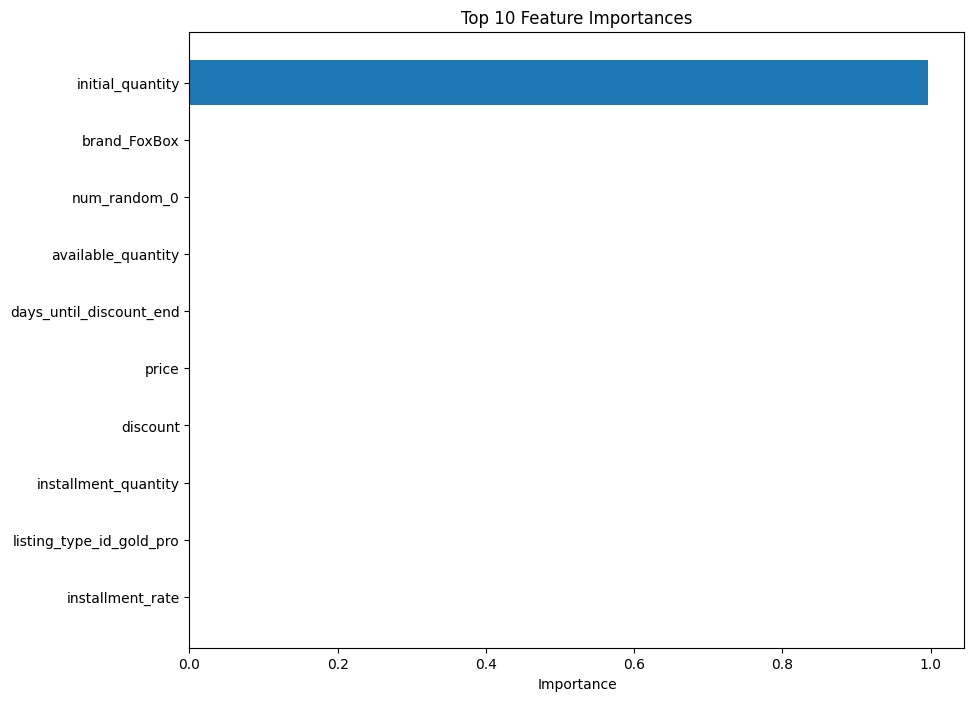

                                               Feature  Importance
0                                     initial_quantity        1.00
1                                         brand_FoxBox        0.00
2                                         num_random_0        0.00
3                                   available_quantity        0.00
4                              days_until_discount_end        0.00
5                                                price        0.00
6                                             discount        0.00
7                                 installment_quantity        0.00
8                             listing_type_id_gold_pro        0.00
9                                     installment_rate        0.00
10                                      cat_random_0_C        0.00
11                        listing_type_id_gold_special        0.00
12                              is_official_store_True        0.00
13                           query_reloj%20inteligente        

In [61]:


# Llamar a la función con el pipeline entrenado y mostrar las 10 características más importantes
feature_importances_df = plot_and_get_feature_importances(rf_best_model, X_train, N=10)

# Mostrar el DataFrame completo con todas las características y sus importancias
print(feature_importances_df)


Elegiremos el mejor estimador, en este caso es XGB

In [50]:
xgb_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [66]:
best_model= xgb_best_model#xgb_pipeline.named_steps['model']

# Best features visualization

## Some features in the domain vs sold_quantity

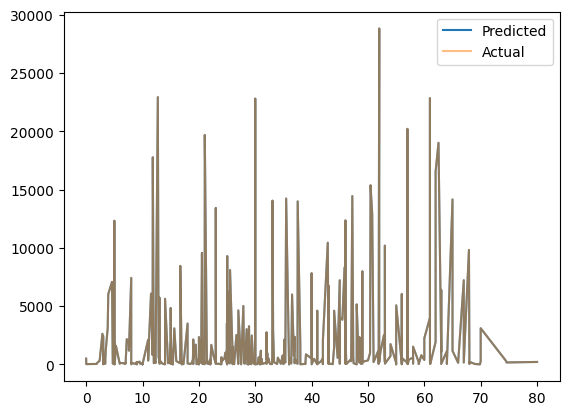

In [110]:
bf = "discount"
domain = X_train[bf].sort_values().drop_duplicates()
domain_index = domain.index
y_hat = best_model.predict(X_train.loc[domain_index])
y = y_train.loc[domain_index.values]

plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha = 0.5, label='Actual')
plt.legend()
plt.show()

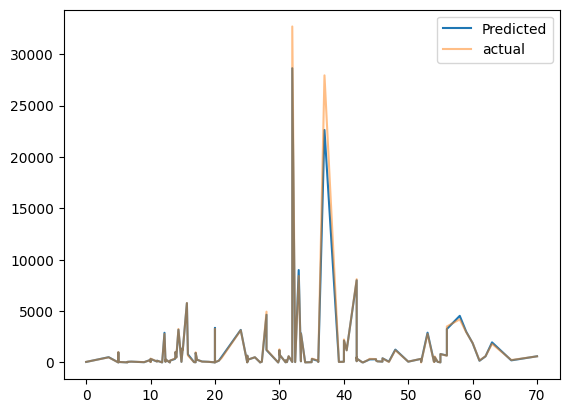

In [109]:
bf = "discount"
domain = X_test[bf].sort_values().drop_duplicates()
domain_index = domain.index
y_hat = best_model.predict(X_test.loc[domain_index])
y = y_test.loc[domain_index.values]

plt.plot(domain.values, y_hat, label='Predicted')
plt.plot(domain.values, y, alpha = 0.5, label='actual')
plt.legend()
plt.show()

## Shap for best model

In [75]:
import shap

In [84]:
model = xgb_best_model
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_quasinormal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['num_random_0']),
                                                 ('num_non_normal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price', 'initial_quantity',
                                                   'availab...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [85]:
import shap
import numpy as np

# Paso 1: Obtener el mejor pipeline del GridSearchCV
best_pipeline = xgb_grid_search.best_estimator_

# Paso 2: Crear un objeto SHAP explainer para el modelo dentro del pipeline
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])

# Paso 3: Transformar los datos usando el preprocesador del pipeline
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

# Paso 4: Calcular los valores SHAP para el conjunto de datos transformado
shap_values = explainer.shap_values(X_train_transformed,check_additivity=False)

# Paso 5: Obtener los nombres de las características después del preprocesamiento
num_quasinormal_features = best_pipeline.named_steps['preprocessor'].transformers_[0][2]
num_non_normal_features = best_pipeline.named_steps['preprocessor'].transformers_[1][2]

# Obtener los nombres de las columnas que salen del OneHotEncoder
ohe = best_pipeline.named_steps['preprocessor'].transformers_[2][1]
cat_features = best_pipeline.named_steps['preprocessor'].transformers_[2][2]
ohe_features = ohe.get_feature_names_out(cat_features)

# Concatenar todos los nombres de las características
feature_names = np.concatenate([num_quasinormal_features, num_non_normal_features, ohe_features])

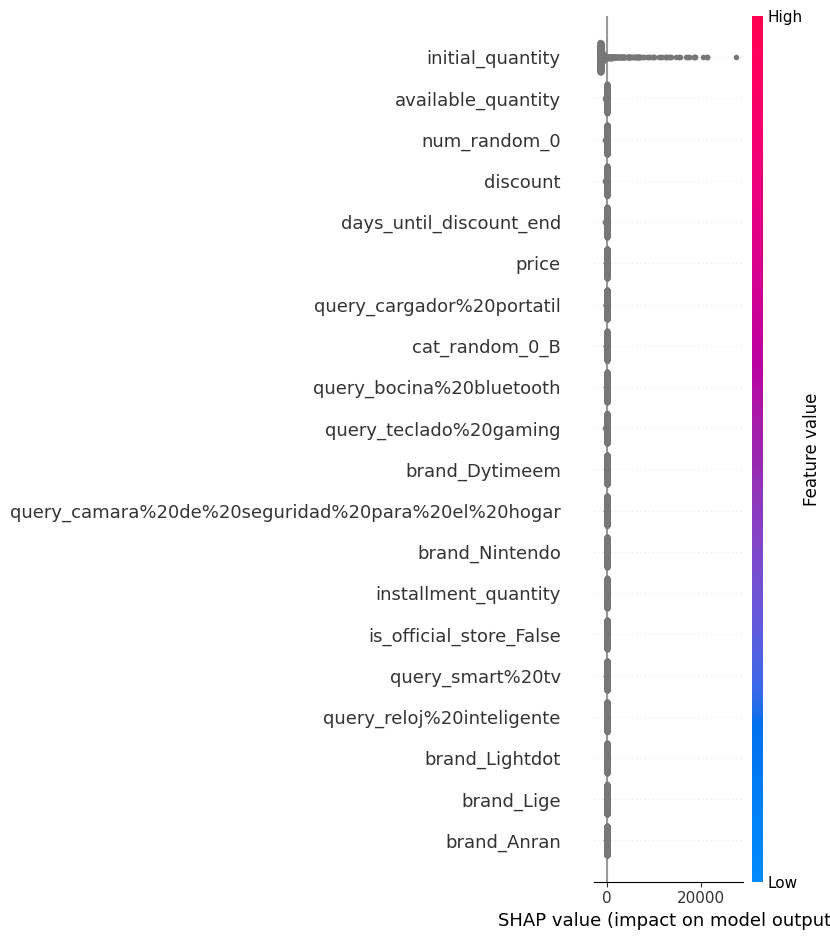

In [94]:
# Paso 6: Visualizar los Valores SHAP

# Gráfico de Resumen (Summary Plot)
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

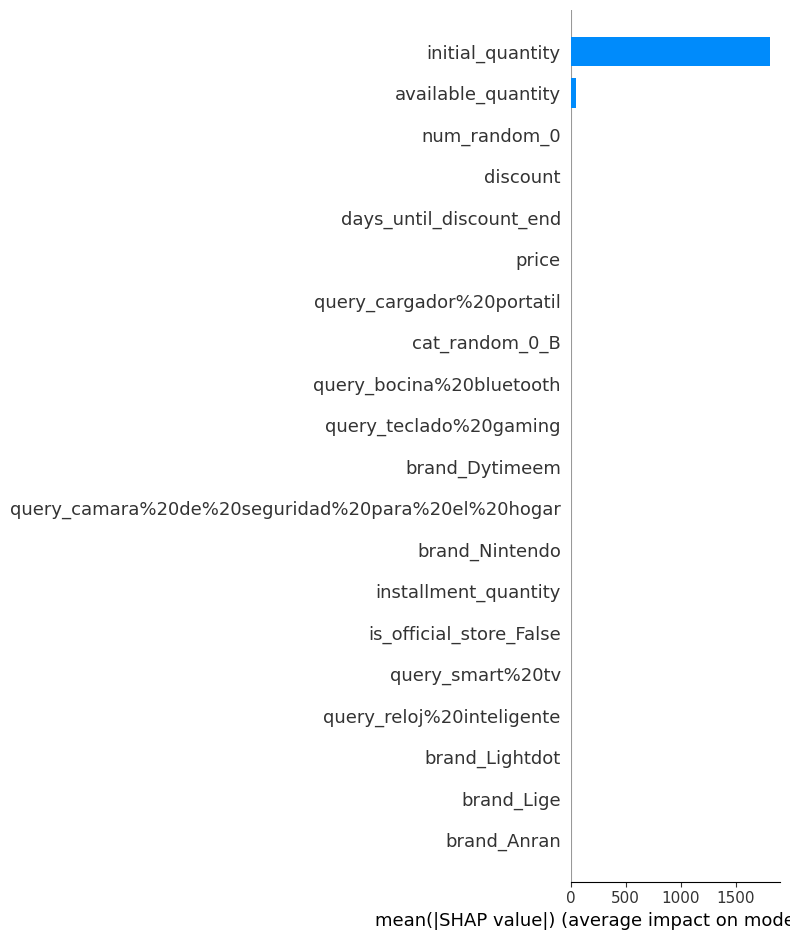

In [95]:
# Gráfico de Barras (Bar Plot)
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

# Guardar los resultados

In [103]:
import joblib

In [106]:
bayes_best_rf_model = RandomForestRegressor(**best_results["result"]["rf_bayes"])
bayes_best_xgb_model = XGBRegressor(**best_results["result"]["xgb_bayes"])
bayes_best_lgbm_model = LGBMRegressor(**best_results["result"]["xgb_bayes"])

joblib.dump(bayes_best_rf_model,   '30_bayes_best_random_forest_model.pkl')
joblib.dump(bayes_best_xgb_model,  '30_bayes_best_xgboost_model.pkl')
joblib.dump(bayes_best_lgbm_model, '30_bayes_best_lightgbm_model.pkl')


joblib.dump(best_results["result"]["rf_gr"],   '30_CV_best_random_forest_model.pkl')
joblib.dump(best_results["result"]["xgb_gr"],  '30_CV_best_xgboost_model.pkl')
joblib.dump(best_results["result"]["lgbm_gr"], '30_CV_best_lightgbm_model.pkl')



['30_CV_best_lightgbm_model.pkl']